This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Beyond text classification: Sequence-to-sequence learning

### A machine translation example

In [1]:
!wget http://www.manythings.org/anki/urd-eng.zip
!unzip -q urd-eng.zip

--2025-02-22 09:57:58--  http://www.manythings.org/anki/urd-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46428 (45K) [application/zip]
Saving to: ‘urd-eng.zip’

urd-eng.zip         100%[===================>]  45.34K   178KB/s    in 0.3s    

2025-02-22 09:57:59 (178 KB/s) - ‘urd-eng.zip’ saved [46428/46428]



In [ ]:
text_file = "urd.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []


In [ ]:
lines

['Hi.\tسلام۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #9020897 (nusrat)',
 'Help!\tمدد۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #1462368 (nabeel_tahir)',
 'Thanks.\tشکریہ۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #2057650 (nava) & #9020893 (nusrat)',
 'We won.\tہم جیت گئے۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #2107675 (CK) & #2123755 (nabeel_tahir)',
 'Beat it.\tبھاگ جائو۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #37902 (CM) & #1610833 (nabeel_tahir)',
 'Beat it.\tدفعہ ہو جائو۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #37902 (CM) & #1610834 (nabeel_tahir)',
 'We lost.\tہم ہار گئے۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #2107666 (CK) & #2123757 (nabeel_tahir)',
 'Good job!\tپہت خوب۔\tCC-BY 2.0 (France) Attribution: tatoeba.org #1021038 (Quazel) & #2097368 (nabeel_tahir)',
 "Let's go!\t!چلو\tCC-BY 2.0 (France) Attribution: tatoeba.org #241077 (CK) & #1473832 (nabeel_tahir)",
 "Tom's up.\tٹام اٹھ چکا ہے۔\tCC-BY 2.0 (Fr

In [ ]:
for line in lines:
    english, urdu, etc = line.split("\t")
    urdu = "[start] " + urdu + " [end]"
    text_pairs.append((english, urdu))

In [ ]:
len(text_pairs)

1154

In [ ]:
import random
print(random.choice(text_pairs))

('I have to go to bed.', '[start] میں سونے کیلئے بستر پر لیٹ چکا ہوں [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_urdu_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_urdu_texts)

In [ ]:
target_vectorization.get_vocabulary()

['',
 '[UNK]',
 '[start]',
 '[end]',
 'میں',
 'ہے۔',
 'نے',
 'وہ',
 'کو',
 'کے',
 'نہیں',
 'اس',
 'مجھے',
 'سے',
 'کی',
 'ٹام',
 'تم',
 'ہوں۔',
 'کیا',
 'کہ',
 'کا',
 'ہو',
 'یہ',
 'ہے',
 'آپ',
 'کر',
 'ہے؟',
 'میرے',
 'ایک',
 'ہیں۔',
 'تھا۔',
 'رہا',
 'اپنی',
 'اور',
 'گا۔',
 'بہت',
 'کچھ',
 'کافی',
 'میری',
 'بھی',
 'پہ',
 'اسے',
 'گھر',
 'کرنے',
 'نہ',
 'مریم',
 'ہو۔',
 'ہم',
 'رہے',
 'ہی',
 'گیا',
 'وقت',
 'سال',
 'تھی۔',
 'تمہیں',
 'ہو؟',
 'گیا۔',
 'پسند',
 'جا',
 'کرنا',
 'لئیے',
 'سکتے',
 'زیادہ',
 'رہی',
 'تو',
 '۔',
 'یہاں',
 'پر',
 'تھا',
 'اپنے',
 'ابھی',
 'آج',
 'ہوا',
 'کبھی',
 'پاس',
 'ٹھیک',
 'سب',
 'تمھیں',
 'گئے',
 'پتہ',
 'میرا',
 'جب',
 'تک',
 'انہوں',
 'کوئی',
 'چاہتا',
 'پہلی',
 'ساتھ',
 'جلدی',
 'تھے۔',
 'بھائی',
 'گی۔',
 'گاڑی',
 'کیا۔',
 'کوشش',
 'کسی',
 'کام',
 'لگ',
 'سکتا',
 'رات',
 'دے',
 'دفعہ',
 'دس',
 'بعد',
 'ابو',
 'آ',
 'ہمیشہ',
 'گے۔',
 'کی۔',
 'کھانے',
 'کس',
 'کتاب',
 'پہلے',
 'مگر',
 'زندگی',
 'دیا۔',
 'ان',
 'اسی',
 'اب',
 'ہوں',
 'ہر',
 'گئی',
 '

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, urd):
    eng = source_vectorization(eng)
    urd = target_vectorization(urd)
    return ({
        "english": eng,
        "urdu": urd[:, :-1],
    }, urd[:, 1:])

def make_dataset(pairs):
    eng_texts, urd_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    urd_texts = list(urd_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, urd_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['urdu'].shape: {inputs['urdu'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['urdu'].shape: (64, 20)
targets.shape: (64, 20)


### Sequence-to-sequence learning with RNNs

**GRU-based encoder**

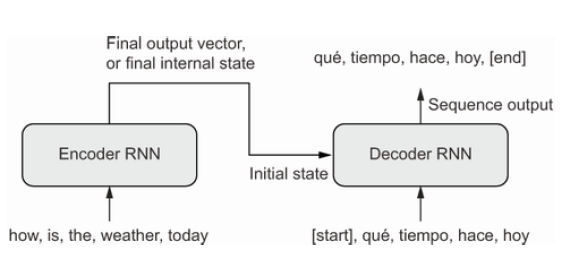

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

**GRU-based decoder and the end-to-end model**

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="urdu")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

**Training our recurrent sequence-to-sequence model**

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
13/13 [==============================] - 19s 377ms/step - loss: 3.3523 - accuracy: 0.1338 - val_loss: 2.8217 - val_accuracy: 0.1326
Epoch 2/15
13/13 [==============================] - 1s 91ms/step - loss: 2.5258 - accuracy: 0.2182 - val_loss: 2.4846 - val_accuracy: 0.2503
Epoch 3/15
13/13 [==============================] - 1s 89ms/step - loss: 2.3120 - accuracy: 0.2386 - val_loss: 2.3772 - val_accuracy: 0.2503
Epoch 4/15
13/13 [==============================] - 1s 89ms/step - loss: 2.1859 - accuracy: 0.2473 - val_loss: 2.3199 - val_accuracy: 0.2720
Epoch 5/15
13/13 [==============================] - 1s 89ms/step - loss: 2.0756 - accuracy: 0.2730 - val_loss: 2.3006 - val_accuracy: 0.2714
Epoch 6/15
13/13 [==============================] - 1s 89ms/step - loss: 1.9795 - accuracy: 0.2868 - val_loss: 2.3650 - val_accuracy: 0.2646
Epoch 7/15
13/13 [==============================] - 1s 90ms/step - loss: 1.8940 - accuracy: 0.3003 - val_loss: 2.2238 - val_accuracy: 0.2980
Epoch 8/15


**Translating new sentences with our RNN encoder and decoder**

In [ ]:
import numpy as np
urd_vocab = target_vectorization.get_vocabulary()
urd_index_lookup = dict(zip(range(len(urd_vocab)), urd_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = urd_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
It won't work.
[start] میں ابھی نہیں ہے۔ [end]
-
Do you know how to use a dictionary?
[start] تم تم کو مہینے کیا ہے؟ [end]
-
Leave more space between the lines.
[start] اس نے سب کو بتادو میں مبتلا کر سکتا ہے۔ [end]
-
I'll be there by eight somehow.
[start] میں نے اسے کمرے میں سوچ سے گا۔ [end]
-
Do you know how to use a dictionary?
[start] تم تم کو مہینے کیا ہے؟ [end]
-
Our teacher said that water boils at 100ºC.
[start] کیا تم کو زیادہ پلیٹیں چاہیے؟ [end]
-
Children who are sixteen years old or younger may not enter the theater.
[start] سائنس سال کی عمر ہو گئی ہے۔ [end]
-
The sun gives us heat and light.
[start] میرے مہربانی ابو کو کتابیں پڑھنے کا شوق ہے۔ [end]
-
How many boys are in this class?
[start] کیا تم پہلی دفعہ جاپان آئی ہے؟ [end]
-
This house is very spacious.
[start] یہ ایک زیادہ پڑھنا ہے۔ [end]
-
I'm a college student.
[start] میں کالج میں پڑھتا ہوں۔ [end]
-
I have asked him.
[start] میں نے یہ نہیں کر رہا ہوں۔ [end]
-
Stay thin.
[start] [end]
-
She's been absent from scho

### Sequence-to-sequence learning with Transformer

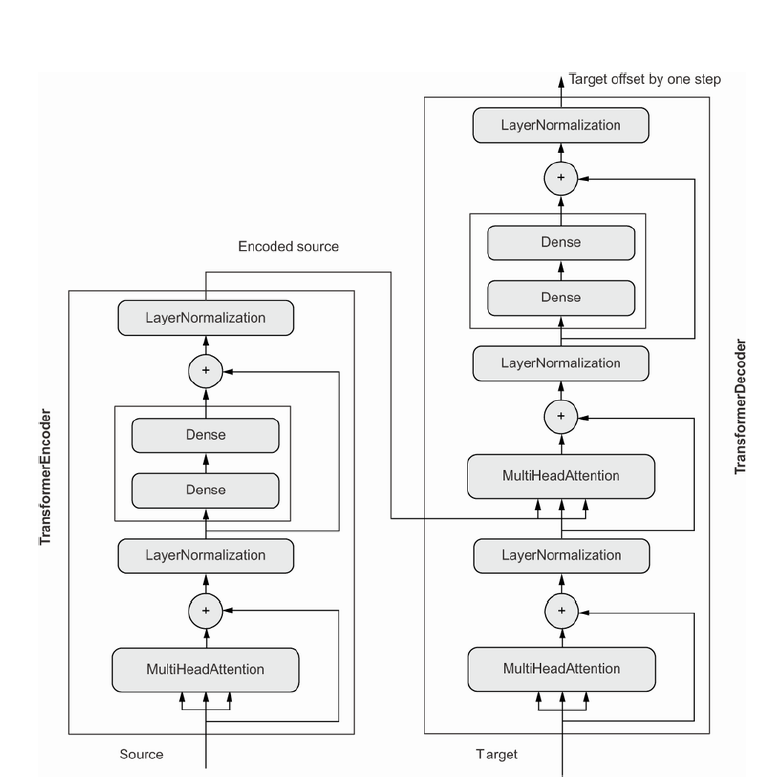

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### The Transformer decoder

**The `TransformerDecoder`**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="urdu")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=30, validation_data=val_ds)


Epoch 1/30
13/13 [==============================] - 6s 130ms/step - loss: 3.3726 - accuracy: 0.1503 - val_loss: 2.6722 - val_accuracy: 0.1797
Epoch 2/30
13/13 [==============================] - 1s 72ms/step - loss: 2.6244 - accuracy: 0.1749 - val_loss: 2.4759 - val_accuracy: 0.2497
Epoch 3/30
13/13 [==============================] - 1s 71ms/step - loss: 2.3710 - accuracy: 0.2522 - val_loss: 2.3498 - val_accuracy: 0.2714
Epoch 4/30
13/13 [==============================] - 1s 70ms/step - loss: 2.2059 - accuracy: 0.2863 - val_loss: 2.3018 - val_accuracy: 0.2974
Epoch 5/30
13/13 [==============================] - 1s 70ms/step - loss: 2.0618 - accuracy: 0.3024 - val_loss: 2.2002 - val_accuracy: 0.3141
Epoch 6/30
13/13 [==============================] - 1s 72ms/step - loss: 1.8821 - accuracy: 0.3475 - val_loss: 2.1100 - val_accuracy: 0.3439
Epoch 7/30
13/13 [==============================] - 1s 72ms/step - loss: 1.7175 - accuracy: 0.3886 - val_loss: 2.1078 - val_accuracy: 0.3457
Epoch 8/30
1

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
urd_vocab = target_vectorization.get_vocabulary()
urd_index_lookup = dict(zip(range(len(urd_vocab)), urd_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = urd_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
How many boys are in this class?
[start] تمھارے خاندان میں کتنے افراد ہے؟ [end]
-
You look just like your older brother.
[start] تم بلکل اپنے بڑے بھائی کی طرح لگتے ہو۔ [end]
-
A refrigerator keeps meat fresh.
[start] ایک دریا قصبے کو دو حصوں میں تقسیم کرتی ہے۔ [end]
-
They are my friends.
[start] وہ اپنے بچوں کے ساتھ ہے؟ [end]
-
How many teams are there?
[start] بینک کے لئیے کتنی پلیٹیں چاہیے؟ [end]
-
Tom broke his glasses.
[start] ٹام کی کبھی ملک سے اتفاق کرتا ہے۔ [end]
-
Paris is the capital of France.
[start] اس کائنات کی ابتدا کیا ہے؟ [end]
-
He respects me.
[start] وہ مجھے آج مل رہا ہے۔ [end]
-
I prefer the black one.
[start] میں سیاہ والے کو ترجیح دوں گا۔ [end]
-
Good night.
[start] صبح بخير۔ [end]
-
You can go wherever you want.
[start] تم جہاں جانا چاہو جا سکتی ہو۔ [end]
-
They are my friends.
[start] وہ اپنے بچوں کے ساتھ ہے؟ [end]
-
It was not in his nature to speak ill of others.
[start] اس کی فطرت میں دوسروں کی برائی کرنا نہیں ہے۔ [end]
-
I owe ten dollars to her.
[start] 

## Summary